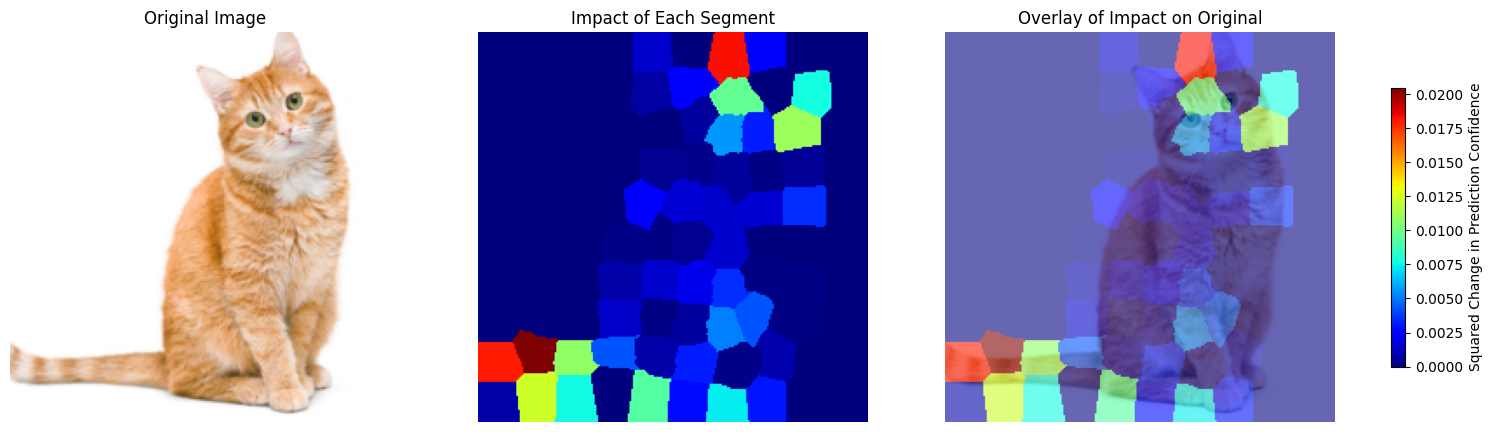

In [49]:
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
from skimage.segmentation import slic
from skimage.color import label2rgb
import matplotlib.colors as mcolors

# Load the image from the internet
response = requests.get("https://media.istockphoto.com/id/1443562748/photo/cute-ginger-cat.jpg?b=1&s=612x612&w=0&k=20&c=Wrn0zBntibGBl7C03Ym3eyiQrqMwItgY_lKt2sMDWzI=")
image = Image.open(BytesIO(response.content))

# Define preprocessing transformation
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

# Preprocess the image
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)  # create a mini-batch as expected by the model

# Segment the image into regions using SLIC
segments = slic(np.array(image.resize((224, 224))), n_segments=100, compactness=50, sigma=1)

# Load pre-trained model
model = models.resnet50(pretrained=True)
model.eval()

# Function to mask a segment
def mask_segment(segment_mask):
    masked_image = input_tensor.clone()
    for i in range(3):  # For each color channel
        masked_image[i][segment_mask] = masked_image[i][segment_mask].mean()
    return masked_image

# Classify the original image
original_output = model(input_batch)
original_prob = torch.nn.functional.softmax(original_output, dim=1)[0].max().item()

# Probabilities after masking segments
changed_probs = []
for i in range(np.max(segments) + 1):
    segment_mask = segments == i
    masked_image = mask_segment(segment_mask)
    masked_output = model(masked_image.unsqueeze(0))
    masked_prob = torch.nn.functional.softmax(masked_output, dim=1)[0].max().item()
    changed_probs.append((original_prob - masked_prob) ** 2)  # Squaring the change to get general changes - Use without squaring to see positive and negative impacts!

# Normalize and map colors
changed_probs = np.array(changed_probs)
norm = mcolors.Normalize(vmin=np.min(changed_probs), vmax=np.max(changed_probs))
cmap = plt.cm.jet

# Create an RGB image for impact visualization
impact_image = np.zeros((*segments.shape, 3))
for i in range(np.max(segments) + 1):
    segment_mask = segments == i
    impact_image[segment_mask] = cmap(norm(changed_probs[i]))[:3]  # Color according to impact, ignoring alpha


# Visualization with colorbar
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
ax[0].imshow(transforms.ToPILImage()(input_tensor))
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(impact_image, aspect='equal')
ax[1].set_title('Impact of Each Segment')
ax[1].axis('off')

# Overlay impact image over the original image
ax[2].imshow(transforms.ToPILImage()(input_tensor))
ax[2].imshow(impact_image, aspect='equal', alpha=0.6)  # Alpha controls transparency
ax[2].set_title('Overlay of Impact on Original')
ax[2].axis('off')

# Add a colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax.ravel().tolist(), orientation='vertical', fraction=0.01, pad=0.04)
cbar.set_label('Squared Change in Prediction Confidence')

plt.show()